<a href="https://colab.research.google.com/github/AbdulQadir8/Image_caption_generator_nn/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Neural Image Caption Generator***

I build a Deep Learning Model using Keras, for generating English Caption text for any given image

**Build a vocabulary of the most commonly occuring words in the caption text**

In [ ]:
# Read the file tokens_clean.txt and store the cleaned captions in a dictionary
import json

content = None

with open("/content/drive/MyDrive/Flickr_Data/Flickr_TextData/tokens_clean.txt",'r') as file:
  content = file.read()

json_acceptable_string = content.replace("'", "\"")
content = json.loads(json_acceptable_string)

In [ ]:
print(type(content))

<class 'dict'>


In [ ]:
content.keys()

dict_keys(['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815', '1007129816_e794419615', '1007320043_627395c3d8', '1009434119_febe49276a', '1012212859_01547e3f17', '1015118661_980735411b', '1015584366_dfcec3c85a', '101654506_8eb26cfb60', '101669240_b2d3e7f17b', '1016887272_03199f49c4', '1019077836_6fc9b15408', '1019604187_d087bf9a5f', '1020651753_06077ec457', '1022454332_6af2c1449a', '1022454428_b6b660a67b', '1022975728_75515238d8', '102351840_323e3de834', '1024138940_f1fefbdce1', '102455176_5f8ead62d5', '1026685415_0431cbf574', '1028205764_7e8df9a2ea', '1030985833_b0902ea560', '103106960_e8a41d64f8', '103195344_5d2dc613a3', '103205630_682ca7285b', '1032122270_ea6f0beedb', '1032460886_4a598ed535', '1034276567_49bb87c51c', '104136873_5b5d41be75', '1042020065_fb3d3ba5ba', '1042590306_95dea0916c', '1045521051_108ebc19be', '1048710776_bb5b0a5c7c', '1052358063_eae6744153', '105342180_4d4a40b47f', '1053804096_ad278b25f1', '1055623002_8195a43714'

In [ ]:
#Iterate over the captions word by word, and append each word to total_words
total_words = []

for key in content.keys():
    for caption in content[key]:
        for i in caption.split():
            total_words.append(i)

print("Total Words = %d" %len(total_words))

Total Words = 437466


In [ ]:
# Compute the frequency of occurrence of each word, and store it in a dictionary of word-freq
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)

print("Number of unique words = " + str(len(freq_cnt.keys())))

Number of unique words = 8441


In [ ]:
# Store the word-freq pairs (from the dictionary freq_cnt) in a list, sorted in decreasing order of frequency
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

In [ ]:
threshold = 5

#Filter off those words whose frequency of occurrence in less than threshold
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
# Store these common words in total_words
total_words = [x[0] for x in sorted_freq_cnt]

print("Number of common unique words = " + str(len(total_words)))

Number of common unique words = 2644


**Prepare Train and Test**

In [ ]:
# Read training and testing image names

train_file_data = ""
test_file_data = ""

with open ("/content/drive/MyDrive/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt", 'r') as file:
    train_file_data = file.read()

with open ("/content/drive/MyDrive/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt", 'r') as file:
    test_file_data = file.read()
     

In [ ]:
# Obtain a list of train and test images
train_data = [img_file_name for img_file_name in train_file_data.split("\n")[:-1]]
test_data = [img_file_name for img_file_name in test_file_data.split("\n")[:-1]]

# Obtain image ID from image file name
train_data = [image.split(".")[0] for image in train_data]
test_data = [image.split(".")[0] for image in test_data]

In [ ]:
train_data[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [ ]:
# For each imageID in train_data, store its captions in a dictionary 

train_content = {}

for imageID in train_data:
    train_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = "startseq " + caption + " endseq"
        train_content[imageID].append(cap_to_append)

In [ ]:
train_content['1007320043_627395c3d8']

['startseq a child playing on a rope net  endseq',
 'startseq a little girl climbing on red roping  endseq',
 'startseq a little girl in pink climbs a rope bridge at the park  endseq',
 'startseq a small child grips onto the red ropes at the playground  endseq',
 'startseq the small child climbs on a red ropes on a playground  endseq']

**Transfer Learning**

*Extract features from Image using a ResNet50 Architecture*

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

model = ResNet50(weights = 'imagenet', input_shape = (224, 224, 3))

In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
from keras.models import Model
model_new = Model (model.input, model.layers[-2].output)

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image (img):
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)

    # Convert 3D tensor to a 4D tendor
    img = np.expand_dims(img, axis=0)

    #Normalize image accoring to ResNet50 requirement
    img = preprocess_input(img)

    return img

(1, 224, 224, 3)


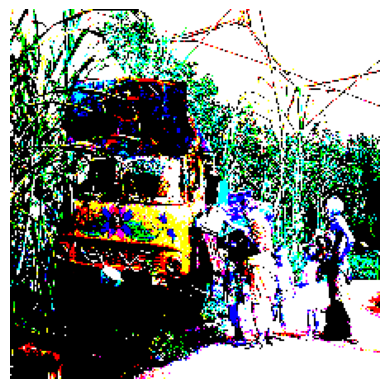

In [ ]:
import matplotlib.pyplot as plt

img = preprocess_image("/content/drive/MyDrive/Flickr_Data/Images/1141739219_2c47195e4c.jpg")
print(img.shape)
plt.imshow(img[0])
plt.axis('off')
plt.show()
     

In [ ]:
# A wrapper function, which inputs an image and returns its encoding (feature vector)
def encode_image (img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)

    feature_vector = feature_vector.reshape((-1,))
    return feature_vector
     

In [ ]:
from time import time

train_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (train_data):
    image_path = "/content/drive/MyDrive/Flickr_Data/Images/" + imageID + ".jpg"
    
    train_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "sec")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 188ms/step
Encoding in progress... STEP 1100
1/1 [==============================] - 0s 131ms/step
Encoding in progress... STEP 1200
1/1 [==============================] - 0s 136ms/step
Encoding in progress... STEP 1300
1/1 [==============================] - 0s 143ms/step
Encoding in progress... STEP 1400
1/1 [==============================] - 0s 129ms/step
Encoding in progress... STEP 1500
1/1 [==============================] - 0s 143ms/step
Encoding in progress... STEP 1600
1/1 [==============================] - 0s 143ms/step
Encoding in progress... STEP 1700
1/1 [==============================] - 0s 189ms/step
Encoding in progress... STEP 1800
1/1 [==============================] - 0s 140ms/step
Encoding in progress... STEP 1900
1/1 [==============================] - 0s 131ms/step
Encoding in progress... STEP 2000
1/1 [==============================] - 0s 140ms/step
Encoding in progress... ST

In [ ]:
# Store the above computed features on the disk
# Use pickle to dump the entire data
import pickle

with open("encoded_train_features.pkl", "wb") as file:
    # Pickle allows to store any object as a file on the disk
    pickle.dump(train_encoding, file)
     

In [ ]:
test_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (test_data):
    image_path = "/content/drive/MyDrive/Flickr_Data/Images/" + imageID + ".jpg"
    
    test_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "s")

1/1 [==============================] - 0s 141ms/step
Encoding in progress... STEP 0
1/1 [==============================] - 0s 141ms/step
Encoding in progress... STEP 100
1/1 [==============================] - 0s 193ms/step
Encoding in progress... STEP 200
1/1 [==============================] - 0s 131ms/step
Encoding in progress... STEP 300
1/1 [==============================] - 0s 130ms/step
Encoding in progress... STEP 400
1/1 [==============================] - 0s 129ms/step
Encoding in progress... STEP 500
1/1 [==============================] - 0s 131ms/step
Encoding in progress... STEP 600
1/1 [==============================] - 0s 184ms/step
Encoding in progress... STEP 700
1/1 [==============================] - 0s 135ms/step
Encoding in progress... STEP 800
1/1 [==============================] - 0s 139ms/step
Encoding in progress... STEP 900
1/1 [==============================] - 0s 152ms/step
Total time taken: 465.06446504592896 s


In [ ]:
with open("encoded_test_features.pkl", "wb") as file:
    pickle.dump(test_encoding, file)

**Pre-process the Captions**

In [ ]:
# Create the word-to-index and index-to-word mappings
word_to_index = {}
index_to_word = {}

for i, word in enumerate(total_words):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [ ]:
print(len(index_to_word))

2644


In [ ]:
print(index_to_word[5])
print(word_to_index['is'])

is
5


In [ ]:
# Add startseq and endseq also to the mappings
index_to_word[2645] = 'startseq'
word_to_index['startseq'] = 2645

index_to_word[2646] = 'endseq'
word_to_index['endseq'] = 2646

VOCAB_SIZE = len(word_to_index) + 1

In [ ]:
print(VOCAB_SIZE)

2647


In [ ]:
import pickle
with open("/content/drive/MyDrive/Flickr_Data/flickr8ktextfiles/word_to_idx.pkl", "wb") as file:
    pickle.dump(word_to_index, file)

In [ ]:
with open("/content/drive/MyDrive/Flickr_Data/flickr8ktextfiles/idx_to_word.pkl", "wb") as file:
    pickle.dump(index_to_word, file)

In [ ]:
# Get the maximum length of a caption
max_len = 0

for cap_list in train_content.keys():
  for caption in train_content[cap_list]:
    max_len = max(max_len, len(caption.split()))

In [ ]:
print(max_len)

38


In [ ]:
# Get the Glove word Embeddings
# This contains 50-dimensional embeddings for 6 billion english words
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-06-04 03:33:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-06-04 03:33:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-06-04 03:33:39--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!ls
!pwd

drive			    glove.6B.100d.txt  glove.6B.50d.txt
encoded_test_features.pkl   glove.6B.200d.txt  glove.6B.zip
encoded_train_features.pkl  glove.6B.300d.txt  sample_data
/content


In [ ]:
# Get the Glove word Embeddings
# This contains 50-dimensional embeddings for 6 billion english words
file = open("/content/drive/MyDrive/Flickr_Data/Flickr_TextData/glove.6B.50d.txt",encoding='utf8') 

In [ ]:
import numpy as np

# Create a mapping from word to embedding
word_to_embedding = {}

for line in file:
  values = line.split()

  word = values[0]
  embedding = np.array(values[1:],dtype='float')
  word_to_embedding[word] = embedding

file.close()


In [ ]:
word_to_embedding['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [ ]:
EMBEDDING_DIM = 50
def get_embedding_matrix():
  embedding_matrix = np.zeros((VOCAB_SIZE,EMBEDDING_DIM))

  for word,index in word_to_index.items():
    embedding = word_to_embedding.get(word)

    if embedding is not None:
      embedding_matrix[index] = embedding
    
  return embedding_matrix

In [ ]:
index_to_embedding = get_embedding_matrix()
print(index_to_embedding.shape)

(2647, 50)


**Define Model Architecture**

*Build a neural Network using keras functional API*

In [ ]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM

#Convert feature vector of image to smaller vector

#Output of ResNet goes into following input layer 
inp_img_features = Input(shape=(2048,))

inp_img1 = Dropout(0.3)(inp_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [ ]:
#Now take Captions as input

#Actual input size will be (batch_size x max_length_of_caption)
#But here we specify only for one example
inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=VOCAB_SIZE, output_dim=50, mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)
# inp_cap3 essentially captures the entire sentence that has been generated till now

In [ ]:
from keras.layers import add

# Decode the inputs

# So effectively, an image (224x224x3) goes through ResNet50
# Then as 2048 dimensional it goes through the above earlier architecture
# The final output is inp_img2 (256 dimensional) which now goes through the Decoder 

# Similarly for the captions which initially have shape (batch_size x max_len)
# Then after passing through Embedding layer comes out as (batch_size x max_len x 50(embedding_size)))
# Then it passes through the above LSTM layer and comes out as inp_cap3 (a 256 dimensional vector)

# Add the two above tensors
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)


In [ ]:
model = Model (inputs=[inp_img_features, inp_cap], outputs=outputs)


In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 38, 50)       132350      ['input_6[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_5[0][0]']                
                                                                                            

In [ ]:
# Preinitialise Embedding layer
model.layers[2].set_weights([index_to_embedding])
model.layers[2].trainable = False

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

**Create Data Loader**

In [ ]:
from keras.utils import pad_sequences
from keras.utils import to_categorical

def data_generator (train_content, train_encoding, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for imageID, cap_list in train_content.items():
            n += 1

            image = train_encoding [imageID]

            for caption in cap_list:
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                for i in range (1, len(idx_seq)):
                    xi = idx_seq[0 : i] # The input sequence of words
                    yi = idx_seq[i] # The next word after the above sequence (this is expected to be predicted)

                    # Add a padding of zeros ao lengths of input sequences become equal
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0] # Take the first row only, since this method inputs & returns a 2D array
                    # Convert the expected word to One Hot vector notation
                    yi = to_categorical([yi], num_classes=VOCAB_SIZE)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]
                    
                    X1, X2, y = [], [], []
                    n=0

**Train Model**

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_content)//batch_size 

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [ ]:
for i in range(epochs):
    # Create an instance of the generator
    generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)
    model.fit(generator, steps_per_epoch=steps)
    model.save('model_' + str(i) + '.h5')

2000/2000 [==============================] - 592s 296ms/step - loss: 2.2709
